In [1]:
!pip install contextily geopandas matplotlib osmnx overpy pandas shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 22.1 MB/s eta 0:00:00


In [136]:
!pip install geopy networkx folium ipyleaflet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.8 MB/s eta 0:00:00


In [139]:
import osmnx as ox
import os
from shapely.geometry import Point
import networkx as nx
import folium
import geopandas as gpd
import pandas as pd
import ipyleaflet
from ipyleaflet import Map, Polyline, Marker

In [7]:
place = '6ème arrondissement, Cotonou'

### Prototype


#### Accessibility and mobility


In [9]:
roads = ox.graph_from_place(place, network_type='all')
public_transport = ox.features_from_place(place, tags={'public_transport': True})

In [10]:
recreation = ox.features_from_place(place, tags={'leisure': ['recreation_ground', 'pitch']})

### Public services, amenity


In [ ]:
healthcare = ox.features_from_place(place, tags={'amenity': ['hospital', 'pharmacy']})
education = ox.features_from_place(place, tags={'amenity': ['school', 'university']})

#### Safety

In [11]:
emergency_services = ox.features_from_place(place, tags={'amenity': ['police', 'fire_station', 'clinic']})


#### Economic

In [13]:
commerce = ox.features_from_place(place, tags={'shop' : True})
employment_centers = ox.features_from_place(place, tags = {'office': True, 'industrial': True})

#### City-wide data collection

In [36]:
def get_ordinal(n):
    if 10 <= n % 100 <= 20:
        suffix = "ème"
    else:
        suffix = {1: "er", 2: "ème", 3: "ème"}.get(n % 10, "ème")
    return f"{n}{suffix}"

arrondissement_numbers = [get_ordinal(i) for i in range(1, 12)]



In [39]:
import osmnx as ox
import os

def get_place_profile(place):
    folderout = f'data/{place}'
    os.makedirs(folderout, exist_ok=True)

    try:
        roads = ox.graph_from_place(place, network_type='all')
        ox.save_graphml(roads, f'{folderout}/roads.graphml')
    except Exception as e:
        print(f"Warning: Unable to fetch road network for {place}. {e}")

    feature_tags = {
        'public_transport': {'public_transport': True},
        'healthcare': {'amenity': ['hospital', 'pharmacy']},
        'education': {'amenity': ['school', 'university']},
        'emergency_services': {'amenity': ['police', 'fire_station', 'clinic']},
        'commerce': {'shop': True},
        'employment_centers': {'office': True, 'industrial': True}
    }

    for feature_name, tags in feature_tags.items():
        try:
            feature_data = ox.features_from_place(place, tags=tags)
            feature_data.to_file(f'{folderout}/{feature_name}.geojson', driver='GeoJSON')
        except Exception as e:
            print(f"Warning: No {feature_name} features found for {place}. Skipping. {e}")

place = '6ème arrondissement, Cotonou'
get_place_profile(place)


In [40]:
os.listdir('data/')

['6eme arrondissement, Cotonou']

In [21]:
os.listdir('data/6eme arrondissement, Cotonou')

['commerce.json',
 'employment_centers.json',
 'education.json',
 'healthcare.json',
 'emergency_services.json',
 'public_transport.json',
 'roads.graphml']

In [41]:
for an in arrondissement_numbers:
  place = an + ' arrondissement, Cotonou'
  admin_a = ox.geocode_to_gdf(place) #administrative arrondissement
  get_place_profile(place)
  admin_a.to_file('data/' + place + '/admin_boundaries.geojson', driver='GeoJSON')
  print(an)


1er
2ème
3ème
4ème
5ème
6ème
7ème
8ème
9ème
10ème
11ème


### Deriving livability parameters

In [51]:
place = "1er arrondissement, Cotonou"
folderin = 'data/' + place


In [52]:
roads_graph = ox.load_graphml(folderin + '/roads.graphml')


In [53]:
public_transport = gpd.read_file(folderin + '/public_transport.geojson')
healthcare = gpd.read_file(folderin + '/healthcare.geojson')
education = gpd.read_file(folderin + '/education.geojson')
emergency_services = gpd.read_file(folderin + '/emergency_services.geojson')
commerce = gpd.read_file(folderin + '/commerce.geojson')
employment_centers = gpd.read_file(folderin + '/employment_centers.geojson')

#### Computing KPIs

In [81]:
# 1. Accessibility and mobility

#computing local measures
crs = 32631
edges = ox.graph_to_gdfs(roads_graph, nodes=False, edges=True)
road_length = edges['length'].sum()/1000 # in km

#total area the network covers
total_area = edges.to_crs(crs).unary_union.convex_hull.area / 1000**2 #in km2
total_area

#road fv
road_density = road_length / total_area

# public transport density
public_transport_density = len(public_transport) / total_area
public_transport_density



<ipython-input-81-accf540fdad6>:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  total_area = edges.to_crs(crs).unary_union.convex_hull.area / 1000**2 #in km2


0.125840748437935

In [63]:
# 2. Public services and amenities

healthcare_accessibility = len(healthcare) / total_area
education_accessibility = len(education) / total_area

In [64]:
# 3. Safety and security
emergency_services_density = len(emergency_services) / total_area

In [67]:
# 4. Economic opportunities

retail_density = len(commerce) / total_area
employment_centers_density = len(employment_centers) / total_area

#### Arrondissement profiler

In [84]:
def characterize_arrondissement(place):
    folderin = 'data/' + place

    files = {
        "public_transport": "public_transport.geojson",
        "healthcare": "healthcare.geojson",
        "education": "education.geojson",
        "emergency_services": "emergency_services.geojson",
        "commerce": "commerce.geojson",
        "employment_centers": "employment_centers.geojson"
    }

    def load_data(key):
        filepath = os.path.join(folderin, files[key])
        try:
            return gpd.read_file(filepath)
        except Exception as e:
            print(f"Warning: {key} data is missing or corrupted for {place}. Error: {e}")
            return None

    roads_graph = ox.load_graphml(folderin + '/roads.graphml')
    public_transport = load_data("public_transport")
    healthcare = load_data("healthcare")
    education = load_data("education")
    emergency_services = load_data("emergency_services")
    commerce = load_data("commerce")
    employment_centers = load_data("employment_centers")


    # 1. Accessibility and Mobility
    crs = 32631

    try:
        edges = ox.graph_to_gdfs(roads_graph, nodes=False, edges=True)
        if edges.crs is None:
            raise ValueError("Road network edges are missing a CRS.")
        edges = edges.to_crs(crs)

        road_length = edges['length'].sum() / 1000  # in km
        total_area = edges.unary_union.convex_hull.area / 1000**2  # in km²
        road_density = road_length / total_area  # km/km²

    except Exception as e:
        print(f"Error computing road metrics for {place}: {e}")
        road_length = total_area = road_density = None

    # Compute feature densities (handling missing datasets)
    def safe_density(data):
        return len(data) / total_area if data is not None and total_area else None

    public_transport_density = safe_density(public_transport)
    healthcare_accessibility = safe_density(healthcare)
    education_accessibility = safe_density(education)
    emergency_services_density = safe_density(emergency_services)
    commerce_density = safe_density(commerce)
    employment_centers_density = safe_density(employment_centers)

    def zero_if_none(value):
      return value if value is not None else 0

    data = {
        "Place": zero_if_none(place),
        "Road Density": zero_if_none(road_density),
        "Public Transport Density": zero_if_none(public_transport_density),
        "Healthcare Accessibility": zero_if_none(healthcare_accessibility),
        "Education Accessibility": zero_if_none(education_accessibility),
        "Emergency Services Density": zero_if_none(emergency_services_density),
        "Retail Density": zero_if_none(commerce_density),
        "Employment Centers Density": zero_if_none(employment_centers_density)
    }

    df = pd.DataFrame([data])
    return df
place = "1er arrondissement, Cotonou"
df = characterize_arrondissement(place)
df


<ipython-input-84-4c1cc5560921>:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  total_area = edges.unary_union.convex_hull.area / 1000**2  # in km²


,Place,Road Density,Public Transport Density,Healthcare Accessibility,Education Accessibility,Emergency Services Density,Retail Density,Employment Centers Density
0,"1er arrondissement, Cotonou",34.269867,0.125841,1.132567,2.390974,0.629204,1.76177,3.020178


In [85]:
place = "5ème arrondissement, Cotonou"
df = characterize_arrondissement(place)
df

<ipython-input-84-4c1cc5560921>:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  total_area = edges.unary_union.convex_hull.area / 1000**2  # in km²


,Place,Road Density,Public Transport Density,Healthcare Accessibility,Education Accessibility,Emergency Services Density,Retail Density,Employment Centers Density
0,"5ème arrondissement, Cotonou",25.41927,3.038665,2.278999,1.519333,1.519333,20.662923,18.231991


#### Data Pipeline

In [71]:
arrondissements = [f for f in os.listdir('data') if '.' not in f]
arrondissements

['4ème arrondissement, Cotonou',
 '10ème arrondissement, Cotonou',
 '3ème arrondissement, Cotonou',
 '2ème arrondissement, Cotonou',
 '9ème arrondissement, Cotonou',
 '1er arrondissement, Cotonou',
 '5ème arrondissement, Cotonou',
 '6ème arrondissement, Cotonou',
 '7ème arrondissement, Cotonou',
 '11ème arrondissement, Cotonou',
 '8ème arrondissement, Cotonou']

In [86]:
df_all = []

for arr in arrondissements:
  df = characterize_arrondissement(arr)
  print(arr, len(df))
  df_all.append(df)
df_all = pd.concat(df_all).set_index('Place')
df_all

<ipython-input-84-4c1cc5560921>:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  total_area = edges.unary_union.convex_hull.area / 1000**2  # in km²
<ipython-input-84-4c1cc5560921>:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  total_area = edges.unary_union.convex_hull.area / 1000**2  # in km²


4ème arrondissement, Cotonou 1
10ème arrondissement, Cotonou 1


<ipython-input-84-4c1cc5560921>:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  total_area = edges.unary_union.convex_hull.area / 1000**2  # in km²


3ème arrondissement, Cotonou 1
2ème arrondissement, Cotonou 1


<ipython-input-84-4c1cc5560921>:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  total_area = edges.unary_union.convex_hull.area / 1000**2  # in km²
<ipython-input-84-4c1cc5560921>:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  total_area = edges.unary_union.convex_hull.area / 1000**2  # in km²


9ème arrondissement, Cotonou 1


<ipython-input-84-4c1cc5560921>:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  total_area = edges.unary_union.convex_hull.area / 1000**2  # in km²


1er arrondissement, Cotonou 1


<ipython-input-84-4c1cc5560921>:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  total_area = edges.unary_union.convex_hull.area / 1000**2  # in km²
<ipython-input-84-4c1cc5560921>:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  total_area = edges.unary_union.convex_hull.area / 1000**2  # in km²


5ème arrondissement, Cotonou 1
6ème arrondissement, Cotonou 1


<ipython-input-84-4c1cc5560921>:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  total_area = edges.unary_union.convex_hull.area / 1000**2  # in km²
<ipython-input-84-4c1cc5560921>:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  total_area = edges.unary_union.convex_hull.area / 1000**2  # in km²


7ème arrondissement, Cotonou 1
11ème arrondissement, Cotonou 1
8ème arrondissement, Cotonou 1


<ipython-input-84-4c1cc5560921>:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  total_area = edges.unary_union.convex_hull.area / 1000**2  # in km²


,Road Density,Public Transport Density,Healthcare Accessibility,Education Accessibility,Emergency Services Density,Retail Density,Employment Centers Density
Place,,,,,,,
"4ème arrondissement, Cotonou",36.353035,0.762805,1.525610,1.525610,0.508537,4.068294,2.542684
"10ème arrondissement, Cotonou",36.295883,0.915802,2.136871,2.136871,1.526336,6.410613,2.442138
"3ème arrondissement, Cotonou",36.498181,0.791228,1.582457,4.219885,0.791228,4.747370,2.109942
"2ème arrondissement, Cotonou",32.674259,0.000000,0.323743,2.428074,0.161872,1.133101,0.971229
"9ème arrondissement, Cotonou",23.643976,0.129201,1.679614,2.584021,1.292010,29.457839,7.752063
"1er arrondissement, Cotonou",34.269867,0.125841,1.132567,2.390974,0.629204,1.761770,3.020178
"5ème arrondissement, Cotonou",25.419270,3.038665,2.278999,1.519333,1.519333,20.662923,18.231991
"6ème arrondissement, Cotonou",33.438292,0.253753,1.522517,3.045034,1.015011,27.151553,2.791281
"7ème arrondissement, Cotonou",38.392984,3.206118,4.580169,3.664135,1.832068,23.816878,7.786287


#### Simple exploration

In [87]:
df_all.describe()

,Road Density,Public Transport Density,Healthcare Accessibility,Education Accessibility,Emergency Services Density,Retail Density,Employment Centers Density
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,32.937472,1.113992,1.794877,2.726704,0.896995,12.407450,5.496357
std,4.720929,1.128334,1.087698,0.860055,0.591602,10.769738,5.062630
min,23.643976,0.000000,0.323743,1.519333,0.000000,1.133101,0.971229
25%,31.426403,0.191477,1.327542,2.263923,0.549944,4.407832,2.492411
50%,34.269867,0.791228,1.582457,2.584021,0.791228,6.410613,3.020178
75%,36.324459,1.515247,2.115470,3.296571,1.405672,22.239901,7.769175
max,38.392984,3.206118,4.580169,4.219885,1.832068,29.457839,18.231991


In [88]:
df_all.corr()

,Road Density,Public Transport Density,Healthcare Accessibility,Education Accessibility,Emergency Services Density,Retail Density,Employment Centers Density
Road Density,1.000000,0.002270,0.284980,0.313491,-0.146161,-0.495248,-0.651747
Public Transport Density,0.002270,1.000000,0.728337,0.082094,0.518844,0.317467,0.734261
Healthcare Accessibility,0.284980,0.728337,1.000000,0.185794,0.689728,0.458387,0.318631
Education Accessibility,0.313491,0.082094,0.185794,1.000000,-0.016053,0.109484,-0.209467
Emergency Services Density,-0.146161,0.518844,0.689728,-0.016053,1.000000,0.661064,0.498314
Retail Density,-0.495248,0.317467,0.458387,0.109484,0.661064,1.000000,0.529586
Employment Centers Density,-0.651747,0.734261,0.318631,-0.209467,0.498314,0.529586,1.000000


In [89]:
feature = 'Road Density'
df_all.sort_values(by=feature, ascending=False).head(5)[[feature]]

,Road Density
Place,
"7ème arrondissement, Cotonou",38.392984
"3ème arrondissement, Cotonou",36.498181
"4ème arrondissement, Cotonou",36.353035
"10ème arrondissement, Cotonou",36.295883
"8ème arrondissement, Cotonou",35.147899


In [90]:
df_all.to_csv("urban_features.csv")

### Computing the livability index

In [ ]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#### Data

In [93]:
df = pd.read_csv('urban_features.csv')
df.head(3)

,Place,Road Density,Public Transport Density,Healthcare Accessibility,Education Accessibility,Emergency Services Density,Retail Density,Employment Centers Density
0,"4ème arrondissement, Cotonou",36.353035,0.762805,1.525610,1.525610,0.508537,4.068294,2.542684
1,"10ème arrondissement, Cotonou",36.295883,0.915802,2.136871,2.136871,1.526336,6.410613,2.442138
2,"3ème arrondissement, Cotonou",36.498181,0.791228,1.582457,4.219885,0.791228,4.747370,2.109942


,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name,geometry,Place
0,2.438541,6.353177,2.462201,6.372596,35404057,relation,3157902,6.362873,2.451279,boundary,administrative,14,0.213396,city_district,4ème Arrondissement,"4ème Arrondissement, Cotonou, Littoral Departm...","POLYGON ((2.43854 6.37135, 2.43859 6.37119, 2....","4ème arrondissement, Cotonou"
0,2.378368,6.376763,2.405916,6.390926,35810334,relation,3157673,6.384008,2.392492,boundary,administrative,14,0.213396,city_district,10ème Arrondissement,"10ème Arrondissement, Cotonou, Littoral Depart...","POLYGON ((2.37837 6.38332, 2.37859 6.38301, 2....","10ème arrondissement, Cotonou"
0,2.437134,6.371346,2.451725,6.397035,35420356,relation,3157901,6.384109,2.444042,boundary,administrative,14,0.213396,city_district,3ème Arrondissement,"3ème Arrondissement, Cotonou, Littoral Departm...","POLYGON ((2.43713 6.38195, 2.43715 6.3818, 2.4...","3ème arrondissement, Cotonou"


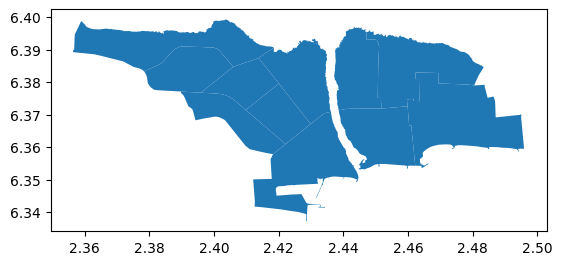

In [ ]:
gdf_admin = []

for arr in os.listdir('data'):
  if '.DS' not in arr:
    gdf = gpd.read_file('data/' + arr + '/admin_boundaries.geojson')
    gdf['Place'] = arr
    gdf_admin.append(gdf)
gdf_admin = pd.concat(gdf_admin)
gdf_admin.plot()
gdf_admin.head(3)

#### Scoring


In [96]:
numerical_features = df.drop('Place', axis=1)

scaler = MinMaxScaler(feature_range=(1, 10))
df_normalized = pd.DataFrame(
    scaler.fit_transform(numerical_features),
    columns=numerical_features.columns,
    index=df.index
)

df_normalized['Place'] = df['Place']
df_normalized = df_normalized[['Place'] + numerical_features.columns.tolist()] # reorder column

df_normalized

,Place,Road Density,Public Transport Density,Healthcare Accessibility,Education Accessibility,Emergency Services Density,Retail Density,Employment Centers Density
0,"4ème arrondissement, Cotonou",8.755202,3.141295,3.541288,1.020921,3.498178,1.932638,1.819378
1,"10ème arrondissement, Cotonou",8.720327,3.570777,4.833768,3.058040,8.498101,2.676895,1.766952
2,"3ème arrondissement, Cotonou",8.843771,3.221083,3.661487,10.000000,4.886896,2.148410,1.593741
3,"2ème arrondissement, Cotonou",6.510374,1.000000,1.000000,4.028517,1.795191,1.000000,1.000000
4,"9ème arrondissement, Cotonou",1.000000,1.362685,3.866921,4.548236,7.346979,10.000000,4.535620
5,"1er arrondissement, Cotonou",7.484031,1.353252,2.710217,3.904878,4.090952,1.199756,2.068350
6,"5ème arrondissement, Cotonou",2.083303,9.529937,5.134291,1.000000,8.463695,7.205473,10.000000
7,"6ème arrondissement, Cotonou",6.976595,1.712318,3.534747,6.084631,5.986225,9.267193,1.949000
8,"7ème arrondissement, Cotonou",10.000000,10.000000,10.000000,8.147880,10.000000,8.207622,4.553466
9,"11ème arrondissement, Cotonou",4.987464,5.980005,2.191035,7.761201,3.905003,4.397924,5.427007


In [98]:
weights = {
    'Road Density': 0.1,
    'Public Transport Density': 0.15,
    'Healthcare Accessibility': 0.1,
    'Education Accessibility': 0.1,
    'Emergency Services Density': 0.1,
    'Retail Density': 0.15,
    'Employment Centers Density': 0.1
}

In [99]:
for feature in df_normalized.columns[1:]:
  df_normalized[feature] = df_normalized[feature] * weights[feature]
df_normalized

,Place,Road Density,Public Transport Density,Healthcare Accessibility,Education Accessibility,Emergency Services Density,Retail Density,Employment Centers Density
0,"4ème arrondissement, Cotonou",0.875520,0.471194,0.354129,0.102092,0.349818,0.289896,0.181938
1,"10ème arrondissement, Cotonou",0.872033,0.535617,0.483377,0.305804,0.849810,0.401534,0.176695
2,"3ème arrondissement, Cotonou",0.884377,0.483162,0.366149,1.000000,0.488690,0.322262,0.159374
3,"2ème arrondissement, Cotonou",0.651037,0.150000,0.100000,0.402852,0.179519,0.150000,0.100000
4,"9ème arrondissement, Cotonou",0.100000,0.204403,0.386692,0.454824,0.734698,1.500000,0.453562
5,"1er arrondissement, Cotonou",0.748403,0.202988,0.271022,0.390488,0.409095,0.179963,0.206835
6,"5ème arrondissement, Cotonou",0.208330,1.429491,0.513429,0.100000,0.846369,1.080821,1.000000
7,"6ème arrondissement, Cotonou",0.697660,0.256848,0.353475,0.608463,0.598623,1.390079,0.194900
8,"7ème arrondissement, Cotonou",1.000000,1.500000,1.000000,0.814788,1.000000,1.231143,0.455347
9,"11ème arrondissement, Cotonou",0.498746,0.897001,0.219104,0.776120,0.390500,0.659689,0.542701


In [103]:
df_normalized['Unified Livability Index'] = df_normalized.iloc[:, 1:].sum(axis=1)

numerical_features = df.drop('Place', axis=1)

scaler_index = MinMaxScaler(feature_range=(1, 10))
df_normalized['Unified Livability Index'] = scaler_index.fit_transform(df_normalized[['Unified Livability Index']])

df_normalized['Unified Livability Index'] = df_normalized['Unified Livability Index'].round(0)

df_normalized[['Place', 'Unified Livability Index']].sort_values(by='Unified Livability Index', ascending=False)

,Place,Unified Livability Index
8,"7ème arrondissement, Cotonou",10.0
6,"5ème arrondissement, Cotonou",7.0
7,"6ème arrondissement, Cotonou",5.0
9,"11ème arrondissement, Cotonou",5.0
4,"9ème arrondissement, Cotonou",5.0
1,"10ème arrondissement, Cotonou",4.0
2,"3ème arrondissement, Cotonou",4.0
10,"8ème arrondissement, Cotonou",4.0
0,"4ème arrondissement, Cotonou",3.0
5,"1er arrondissement, Cotonou",2.0


### Visual

In [107]:
gdf_admin['Place'] = gdf_admin['Place'].astype(str)
df_normalized['Place'] = df_normalized['Place'].astype(str)

gdf_index = gdf_admin[['geometry', 'Place']].merge(df_normalized[['Place', 'Unified Livability Index']], on='Place')
gdf_index

,geometry,Place,Unified Livability Index
0,"POLYGON ((2.43854 6.37135, 2.43859 6.37119, 2....","4ème arrondissement, Cotonou",3.0
1,"POLYGON ((2.37837 6.38332, 2.37859 6.38301, 2....","10ème arrondissement, Cotonou",4.0
2,"POLYGON ((2.43713 6.38195, 2.43715 6.3818, 2.4...","3ème arrondissement, Cotonou",4.0
3,"POLYGON ((2.44713 6.39302, 2.44857 6.39315, 2....","2ème arrondissement, Cotonou",1.0
4,"POLYGON ((2.35643 6.38991, 2.35645 6.38918, 2....","9ème arrondissement, Cotonou",5.0
5,"POLYGON ((2.45964 6.37471, 2.45985 6.3726, 2.4...","1er arrondissement, Cotonou",2.0
6,"POLYGON ((2.41209 6.35012, 2.41262 6.34326, 2....","5ème arrondissement, Cotonou",7.0
7,"POLYGON ((2.41381 6.38744, 2.42005 6.37956, 2....","6ème arrondissement, Cotonou",5.0
8,"POLYGON ((2.4098 6.37147, 2.41104 6.37038, 2.4...","7ème arrondissement, Cotonou",10.0
9,"POLYGON ((2.38974 6.37711, 2.38978 6.3767, 2.3...","11ème arrondissement, Cotonou",5.0


<ipython-input-127-5ffd801fbe36>:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(gdf_index.geometry.centroid.x, gdf_index.geometry.centroid.y, gdf_index['Place']):


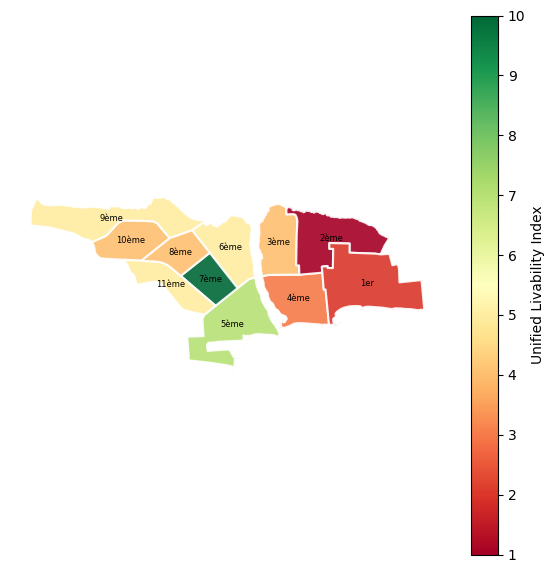

In [127]:
f, ax = plt.subplots(1, 1, figsize=(7, 7))

gdf_index.plot(
    ax=ax,
    edgecolor='w',
    linewidth=1.5,
    alpha=0.9,
    column='Unified Livability Index',
    cmap='RdYlGn',
    legend=True,
    legend_kwds={'label': "Unified Livability Index", 'orientation': "vertical"}
)

for x, y, label in zip(gdf_index.geometry.centroid.x, gdf_index.geometry.centroid.y, gdf_index['Place']):
    import re
    arr_index = re.search(r'(\d+(er|ème)?)', label).group(0)
    ax.text(x, y, arr_index, fontsize=6, ha='center', va='center')

ax.axis('off')
plt.show()

### Distance calculation between two locations

In [129]:
def get_coordinates(place_name, gdf):
  try:
    place = gdf[gdf['Place'] == place_name].iloc[0]
    return {'latitude': place['latitude'], 'longitude': place['longitude']}
  except IndexError:
    print(f"Place '{place_name}' not found in the GeoDataFrame.")
    return None

coordinates = get_coordinates("1er arrondissement, Cotonou", gdf_admin)

if coordinates:
  print(f"Latitude: {coordinates['latitude']}, Longitude: {coordinates['longitude']}")

Latitude: 6.368937102407229, Longitude: 2.475678502790599


In [132]:
from geopy.distance import geodesic

def calculate_distance(origin, destination):
    distance = geodesic(origin, destination).kilometers
    return distance

arr_1_coordinates = get_coordinates("1er arrondissement, Cotonou", gdf_admin)

origin = (arr_1_coordinates['latitude'], arr_1_coordinates['longitude'])

arr_2_coordinates = get_coordinates("9ème arrondissement, Cotonou", gdf_admin)

destination = (arr_2_coordinates['latitude'], arr_2_coordinates['longitude'])

distance = calculate_distance(origin, destination)
print(f"Distance between origin and destination: {distance} km")


Distance between origin and destination: 10.303156315859093 km


In [140]:
from shapely.geometry import Point

def find_arrondissement(latitude, longitude, gdf):
  point = Point(longitude, latitude)
  for index, row in gdf.iterrows():
    if row['geometry'].contains(point):
      return row['Place']
  return None

arrondissement = find_arrondissement(6.377912158277681, 2.4319267272949223, gdf_admin)

if arrondissement:
  print(f"The location is in: {arrondissement}")
else:
  print("The location is not within any known arrondissement.")

The location is in: 6ème arrondissement, Cotonou


### Optimizing routes between two points

In [141]:
arr_1_coordinates = get_coordinates("1er arrondissement, Cotonou", gdf_admin)
arr_2_coordinates = get_coordinates("9ème arrondissement, Cotonou", gdf_admin)

origin = (arr_1_coordinates['latitude'], arr_1_coordinates['longitude'])
destination = (arr_2_coordinates['latitude'], arr_2_coordinates['longitude'])

G = ox.graph_from_place("Cotonou, Bénin", network_type='drive')
origin_node = ox.distance.nearest_nodes(G, X=origin[1], Y=origin[0])
destination_node = ox.distance.nearest_nodes(G, X=destination[1], Y=destination[0])
# using dijkstra algorithm
shortest_path = nx.shortest_path(G, origin_node, destination_node, weight='length')
path_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in shortest_path]

map = Map(center=[(origin[0] + destination[0])/2, (origin[1] + destination[1])/2], zoom=13)

origin_marker = Marker(location=origin, draggable=False, title="1er arrondissement")
destination_marker = Marker(location=destination, draggable=False, title="2ème arrondissement")
map.add_layer(origin_marker)
map.add_layer(destination_marker)

path_line = Polyline(locations=path_coords, color="orange", fill=False)
map.add_layer(path_line)

map

Map(center=[np.float64(6.380294270903215), np.float64(2.430519661505566)], controls=(ZoomControl(options=['pos…